In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Animal Welfare Center dataset

In [3]:
original_data = pd.read_csv("kaggle_files/animal_welfare_center.csv")

In [4]:
data = original_data.copy()

In [5]:
data.head()

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [6]:
data.outcome_type.value_counts()

Adoption           12967
Transfer           10345
Return to Owner     9718
Euthanasia          4144
Died                2829
Missing             2599
Relocate            2573
Rto-Adopt           2450
Disposal             178
Name: outcome_type, dtype: int64

#### We will focus only on the animals that got adopted, trying to predict a model for adoption,

In [7]:
data = data[data['outcome_type'].isin(["Adoption", "Rto-Adopt", "Return to Owner"])] 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25135 entries, 0 to 47801
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           25135 non-null  object 
 1   dob_year                    25135 non-null  int64  
 2   dob_month                   25135 non-null  int64  
 3   age_upon_intake             25135 non-null  object 
 4   animal_type                 25135 non-null  object 
 5   breed                       25135 non-null  object 
 6   color                       25135 non-null  object 
 7   intake_condition            25135 non-null  object 
 8   intake_type                 25135 non-null  object 
 9   sex_upon_intake             25134 non-null  object 
 10  count                       25135 non-null  int64  
 11  age_upon_intake_(days)      25135 non-null  int64  
 12  age_upon_intake_(years)     25135 non-null  float64
 13  age_upon_intake_age_group   251

## Data Cleaning

In [9]:
# List of columns that have unnecessary/redundant information
drop_columns = ["age_upon_intake", "count", "age_upon_intake_(days)", "intake_datetime", "time_in_shelter",
                "intake_monthyear" , "age_upon_outcome", "date_of_birth", "age_upon_outcome_(days)",
                "age_upon_intake_age_group", "age_upon_outcome_age_group",
                "outcome_datetime", "outcome_monthyear", "outcome_number", "intake_hour", "outcome_hour"]

In [10]:
# select numerical features for correlations
numerical = data.select_dtypes(np.number)

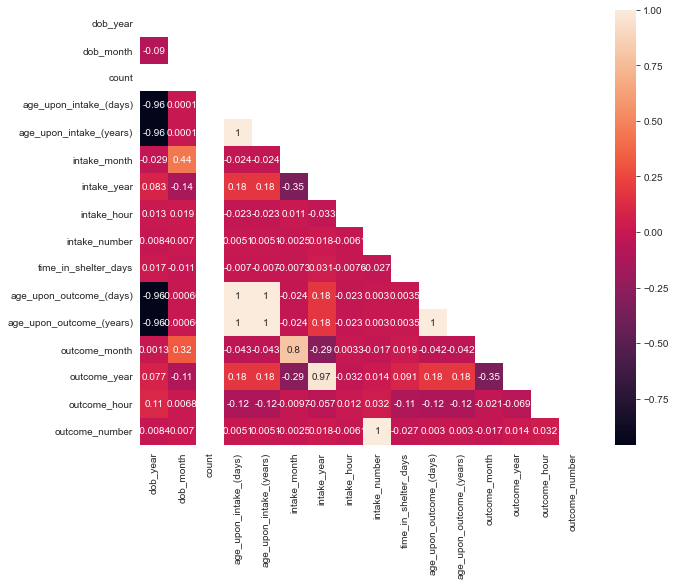

In [11]:
correlations = numerical.corr() # create the correlations

mask = np.zeros_like(correlations) # create an array with size of correlations

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations, mask=mask, annot=True)
plt.show()

#### Outcome and income values are almost the same because the duration that animals spent at the center are generally short, therefore high correlations. More columns need to be dropped.

In [12]:
# Dropping more columns after reducing the data
drop_columns.extend(["dob_year", "age_upon_outcome_(days)", "age_upon_outcome_(years)", "outcome_year"]) # use extend([]) instead of multiple append()

In [13]:
len(data.animal_id_outcome.unique())/len(data) # how many unique animals are in the dataset

0.877501491943505

#### The data has multiple entries for the same animal. Enough data will remain after removing the duplicate intakes. The duplicates will be dropped.

In [14]:
# Remove duplicate rows for same animal
data = data[data['intake_number']== 1]

In [15]:
# now useless columns
drop_columns.extend(["animal_id_outcome", "intake_number"]) # use extend([]) instead of multiple append()

data = data.drop(columns=drop_columns)                      # dropping unnecessary columns

In [16]:
# Change column names for better understanding
data.rename(columns={'age_upon_intake_(years)':'age(years)',
                        "sex_upon_intake" : "sex"}, inplace=True)

In [17]:
# Exploring the values in our data to look for values that are unclear
for i in data.columns:
        print("------------------------")
        x = data[i].value_counts()
        print(x)

------------------------
4     2206
3     1991
5     1878
10    1782
6     1715
8     1682
9     1676
1     1675
12    1669
7     1634
2     1559
11    1517
Name: dob_month, dtype: int64
------------------------
Dog      14705
Cat       6147
Other       74
Bird        58
Name: animal_type, dtype: int64
------------------------
Domestic Shorthair Mix                             4683
Pit Bull Mix                                       1704
Chihuahua Shorthair Mix                            1578
Labrador Retriever Mix                             1302
German Shepherd Mix                                 580
                                                   ... 
American Staffordshire Terrier/American Bulldog       1
Jack Russell Terrier/Miniature Schnauzer              1
Boxer/Cardigan Welsh Corgi                            1
Pembroke Welsh Corgi/Pit Bull                         1
Mastiff/Bloodhound                                    1
Name: breed, Length: 1426, dtype: int64
---------------

In [18]:
no_age = data[data["age(years)"]==0]                              # select data where age is 0
# print(no_age[no_age.dob_month - no_age.intake_month])
no_age_list= list(no_age[(no_age.dob_month - no_age.intake_month ) >0 ].index) # get list of those indices 
data.loc[no_age_list, "dob_month"] = data["dob_month"] - 1                     # reduce dob_month by 1 to match intake_month

#### The zeros in the "age_upon_intake_(years)" are not missing values, they indicate a very young (or new born) animal at the Center. Some wrong values were cleaned.

In [19]:
data["sex"] = data['sex'].replace('Unknown', np.NaN)  # Replacing "Unknown" strings with Nans

In [20]:
data.sex.value_counts(dropna =False)/len(data) # How much of the data are NaNs now?

Intact Male      0.304422
Intact Female    0.271350
Neutered Male    0.220072
Spayed Female    0.196102
NaN              0.008054
Name: sex, dtype: float64

#### Filling missing values randomly with values from that column.

In [21]:
def random_nans(df, col):                                   # take the dataframe and the specified column
    print("NaNs before:", df[col].isna().sum())             # sanity check for NaNs before removing
    
    x = df.copy()                                           # copy dataframe for mask
    mask = df[col].isna()                                   # create the mask correlating to NaNs
    sexes = df[col].dropna().unique()                       # get unique entries in specified column
    
    x.loc[mask, col] = random.choices(sexes, k=mask.sum())  # apply mask to copied dataframe and replace NaNs 
                                                            # with random entries from the list
    print("NaNs after:" , x[col].isna().sum())              # sanity check for NaNs after removing
    return x

In [22]:
data = random_nans(data, "sex")

NaNs before: 169
NaNs after: 0


In [23]:
def group_by_value(data,col,num,rename):                         # take 4 arguments: dataframe, column to modify,
                                                                 # cut of number and string u want to rename the NaNs to
    data2 = data.copy()
    
    breed1 = pd.DataFrame([data2[col].value_counts()<num]).T     # select dataframe where column has values less than specified
    mask1 = breed1.loc[breed1[col]==True].index                  # create mask with index of selected data
    df1 = data2[data2[col].isin(mask1)]                          # create dataframe with mask
    df1[col] = rename                                            # rename all entries in column

    #similar to code above, this time with values >= to specified number
    breed2 = pd.DataFrame([data2[col].value_counts()>=num]).T
    mask2 = breed2.loc[breed2[col]==True].index
    df2 = data2[data2[col].isin(mask2)]

    df = pd.concat([df1,df2] , axis = 0)                          # Combine modified dataframe with unmodified 
    
    print("The", col, "column now has", len(df[col].value_counts()), "unique entries")
    return df

In [24]:
data = group_by_value(data, "breed", 100, "Other")
data = group_by_value(data,"color", 120, "Other")

The breed column now has 26 unique entries
The color column now has 39 unique entries


In [25]:
data = data.reset_index(drop=True)

### Extracting data for visualization

In [26]:
tableau = data.copy()
tableau.to_excel("Animal_Welfare_Center.xlsx", index = False)

## Data Exploration

In [27]:
iqr = np.percentile(data["time_in_shelter_days"], 75) - np.percentile(data["time_in_shelter_days"], 25)
upper_limit = np.percentile(data["time_in_shelter_days"], 75) + 1.5 * iqr
lower_limit = np.percentile(data["time_in_shelter_days"], 25) - 1.5 * iqr

mask_outlier = (data.time_in_shelter_days > upper_limit) | (data.time_in_shelter_days < lower_limit) # condition of being an outlier
mask_not_outlier = ( data.time_in_shelter_days <= upper_limit) & (data.time_in_shelter_days >= lower_limit) # condition of not not being outlier 
outliers_time_in_shelter_days = data[mask_outlier] # here it is the dataset with the outliers of time_in_shelter_days
cleaned_outliers_time_in_shelter_days = data[mask_not_outlier ] # here we have the dataset without outliers of time_in_shelter_days
#display(cleaned_outliers)

data_no_outl = data[(data.time_in_shelter_days < upper_limit) & (data.time_in_shelter_days > lower_limit)]
print("Shape of dataset with outliers:", data.shape)
print("Shape of dataset without outliers:", data_no_outl.shape)

Shape of dataset with outliers: (20984, 16)
Shape of dataset without outliers: (18070, 16)


<AxesSubplot:ylabel='Density'>

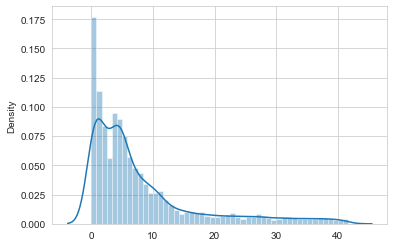

In [28]:
# VISUALIZE VARIABLES VS TARGET
y = data_no_outl.time_in_shelter_days
sns.distplot(x=y)

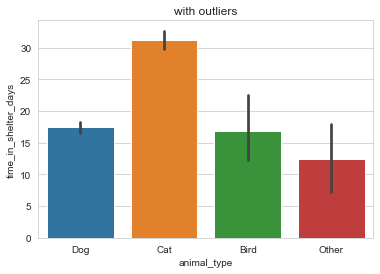

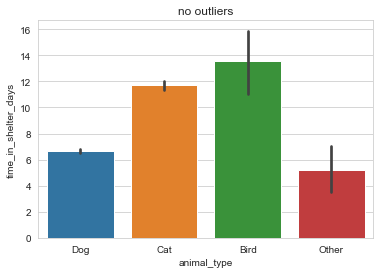

In [29]:
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data) # mean of the 3 categories
plt.title("with outliers")
plt.show()
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data_no_outl) # mean of the 3 categories
plt.title("no outliers")
plt.show()

In [30]:
# average time in shelter by type
print("with outliers:" ,data[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean())
print("-------------")
print("no outliers:" ,data_no_outl[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean()) 

with outliers: animal_type
Bird     16.903257
Cat      31.245074
Dog      17.408520
Other    12.408164
Name: time_in_shelter_days, dtype: float64
-------------
no outliers: animal_type
Bird     13.550227
Cat      11.691861
Dog       6.659396
Other     5.187687
Name: time_in_shelter_days, dtype: float64


# What can we see here?

In [31]:
#sns.scatterplot(x="breed", y="time_in_shelter_days", data=data) 

In [32]:
#fig, ax = plt.subplots(1,1)
#sns.histplot(x="time_in_shelter_days", hue= "color", data=data, bins=400)
#ax.set_xlim((0,50))
#plt.show()

In [33]:
#sns.boxplot(cleaned_outliers_time_in_shelter_days["time_in_shelter_days"])

In [34]:
#sns.pairplot(data)

# Feature Engineering

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20984 entries, 0 to 20983
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dob_month             20984 non-null  int64  
 1   animal_type           20984 non-null  object 
 2   breed                 20984 non-null  object 
 3   color                 20984 non-null  object 
 4   intake_condition      20984 non-null  object 
 5   intake_type           20984 non-null  object 
 6   sex                   20984 non-null  object 
 7   age(years)            20984 non-null  float64
 8   intake_month          20984 non-null  int64  
 9   intake_year           20984 non-null  int64  
 10  intake_weekday        20984 non-null  object 
 11  time_in_shelter_days  20984 non-null  float64
 12  sex_upon_outcome      20983 non-null  object 
 13  outcome_month         20984 non-null  int64  
 14  outcome_weekday       20984 non-null  object 
 15  outcome_type       

# Outlier Analysis

In [36]:
feature = "time_in_shelter_days"    # target feature                

In [37]:
# Function to scale categorical data, either with frequency encoding or dummification
def encoding(data, le):                                          # dataset, option to use frequency encoding
    numerical = data.select_dtypes(np.number)                                         # numerical data
    categorical = data.select_dtypes(object)                                          # categorical data
    if le:                                                                            # enable frequency encoding?
        for col in categorical.columns:
            categorical[col]=label.fit_transform(categorical[col])
    else: 
        categorical = pd.get_dummies(categorical, drop_first = True)                  # if frequency encoding was not enabled
                                                                                      # dummification of features will be used
        
    data = pd.concat([numerical, categorical] , axis = 1)           # concatenate both numerical and categorical dataframes
    return data                                                     # return data

In [38]:
def model_inplace(data, feature, scaler, model):
    X = data[data.columns.drop(feature)]  # features for regression
    y = data[feature]                     # target feature         
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train,y_train)
    print(scaler, model)
    print("train:", model.score(X_train, y_train))
    print("test:", model.score(X_test, y_test))
    try:
        feature_importance = pd.DataFrame({ 
        "feature_names": X.columns,
        "coefficients": abs(model.coef_)
        })
        feature_importance = feature_importance.sort_values(["coefficients"], ascending=False) # Ranking the features
    except:
        return 0
    return feature_importance

In [39]:
# different scaler
poly = PolynomialFeatures(degree=3)
label = LabelEncoder()
stdscal = StandardScaler()
minmax = MinMaxScaler()
scaler_list = [stdscal, minmax]

#different Regresser

lreg = LinearRegression()
ridge = Ridge(alpha = 900)
lasso = Lasso(alpha = 0)
reg_list = [lreg, ridge, lasso]

In [40]:
le = True
data_enc = encoding(data, le)
data_no_outl_enc = encoding(data_no_outl, le)
data_list = [data_enc, data_no_outl_enc]

In [41]:
for encoded in data_list:
    print("NEW DATA")
    for scaler in scaler_list:
        print("")
        for reg in reg_list:
            feature_importance = model_inplace(encoded, feature, scaler, reg)
            print("")
            display(feature_importance)
    print("------------------------------------")  

NEW DATA

StandardScaler() LinearRegression()
train: 0.04668080531520791
test: 0.02928026212145851



,feature_names,coefficients
14,outcome_type,7.379033
4,outcome_month,5.091576
5,animal_type,5.069922
2,intake_month,4.199042
8,intake_condition,3.330245
1,age(years),2.815688
12,sex_upon_outcome,2.737246
3,intake_year,2.218516
10,sex,2.078556
7,color,1.872754


StandardScaler() Ridge(alpha=900)
train: 0.04644267536124791
test: 0.030495934509335076



,feature_names,coefficients
14,outcome_type,7.037143
5,animal_type,4.831616
4,outcome_month,4.109086
2,intake_month,3.182657
8,intake_condition,3.146793
12,sex_upon_outcome,2.627504
1,age(years),2.471606
3,intake_year,2.142671
10,sex,1.894204
7,color,1.803701


StandardScaler() Lasso(alpha=0)
train: 0.046680805315207685
test: 0.02928026212145851



,feature_names,coefficients
14,outcome_type,7.379033
4,outcome_month,5.091576
5,animal_type,5.069922
2,intake_month,4.199042
8,intake_condition,3.330245
1,age(years),2.815688
12,sex_upon_outcome,2.737246
3,intake_year,2.218516
10,sex,2.078556
7,color,1.872754



MinMaxScaler() LinearRegression()
train: 0.046680805315207685
test: 0.029280262121458622



,feature_names,coefficients
8,intake_condition,39.179446
5,animal_type,32.397353
14,outcome_type,21.843100
1,age(years),19.027799
12,sex_upon_outcome,17.542716
4,outcome_month,15.655314
2,intake_month,13.047048
3,intake_year,11.470311
9,intake_type,8.149647
7,color,5.955723


MinMaxScaler() Ridge(alpha=900)
train: 0.03369026686900656
test: 0.0239579892306363



,feature_names,coefficients
14,outcome_type,15.975842
5,animal_type,10.204790
12,sex_upon_outcome,5.809699
4,outcome_month,5.244988
7,color,4.888573
8,intake_condition,4.609857
9,intake_type,4.589884
3,intake_year,4.583276
2,intake_month,3.252825
10,sex,2.516248


MinMaxScaler() Lasso(alpha=0)
train: 0.046680805315207796
test: 0.029280262121458733



,feature_names,coefficients
8,intake_condition,39.179446
5,animal_type,32.397353
14,outcome_type,21.843100
1,age(years),19.027799
12,sex_upon_outcome,17.542716
4,outcome_month,15.655314
2,intake_month,13.047048
3,intake_year,11.470311
9,intake_type,8.149647
7,color,5.955723


------------------------------------
NEW DATA

StandardScaler() LinearRegression()
train: 0.15902171746838412
test: 0.14819086661416647



,feature_names,coefficients
14,outcome_type,2.080289
5,animal_type,1.639198
10,sex,1.099094
4,outcome_month,0.877925
12,sex_upon_outcome,0.593709
9,intake_type,0.529710
7,color,0.494397
2,intake_month,0.436322
11,intake_weekday,0.319928
1,age(years),0.276671


StandardScaler() Ridge(alpha=900)
train: 0.15855616111253878
test: 0.14832620882754188



,feature_names,coefficients
14,outcome_type,1.975486
5,animal_type,1.557186
10,sex,1.034252
4,outcome_month,0.643328
12,sex_upon_outcome,0.561743
9,intake_type,0.509148
7,color,0.474573
1,age(years),0.323797
11,intake_weekday,0.296560
6,breed,0.246649


StandardScaler() Lasso(alpha=0)
train: 0.15902171746838412
test: 0.14819086661416636



,feature_names,coefficients
14,outcome_type,2.080289
5,animal_type,1.639198
10,sex,1.099094
4,outcome_month,0.877925
12,sex_upon_outcome,0.593709
9,intake_type,0.529710
7,color,0.494397
2,intake_month,0.436322
11,intake_weekday,0.319928
1,age(years),0.276671



MinMaxScaler() LinearRegression()
train: 0.15902171746838412
test: 0.14819086661416647



,feature_names,coefficients
5,animal_type,10.876128
14,outcome_type,6.213796
12,sex_upon_outcome,3.705170
10,sex,3.051997
9,intake_type,2.702809
4,outcome_month,2.687046
1,age(years),1.853505
7,color,1.560801
8,intake_condition,1.508462
2,intake_month,1.340691


MinMaxScaler() Ridge(alpha=900)
train: 0.12806449672361486
test: 0.12047899486764913



,feature_names,coefficients
14,outcome_type,4.488752
5,animal_type,3.174455
10,sex,2.349729
9,intake_type,1.377277
7,color,1.350482
1,age(years),1.314436
12,sex_upon_outcome,1.147308
6,breed,1.030658
4,outcome_month,0.997622
3,intake_year,0.597288


MinMaxScaler() Lasso(alpha=0)
train: 0.15902171746838412
test: 0.14819086661416647



,feature_names,coefficients
5,animal_type,10.876128
14,outcome_type,6.213796
12,sex_upon_outcome,3.705170
10,sex,3.051997
9,intake_type,2.702809
4,outcome_month,2.687046
1,age(years),1.853505
7,color,1.560801
8,intake_condition,1.508462
2,intake_month,1.340691


------------------------------------


#### Score on Data without outliers is better.

In [42]:
X = data_no_outl_enc[data_no_outl_enc.columns.drop(feature)]  # features for regression
y = data_no_outl_enc[feature]                         # target feature         
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
X_train = stdscal.fit_transform(X_train)
X_test = stdscal.transform(X_test)

In [43]:
# learn is what is the best alhpa on Lasso
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(lasso, param_grid= params, cv=10, verbose=1)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Lasso", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Lasso", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces

Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [-0.11360961 -0.27667089 -0.43632205 -0.16309354  0.87792487 -1.63919785
 -0.23874194 -0.49439709  0.11901718 -0.52971026 -1.09909443  0.31992751
  0.5937085  -0.06390152 -2.08028882]
score on train set: 0.15902171746838412
score on test set: 0.14819086661416636
columns that were removed by Lasso Index([], dtype='object')
columns that were NOT removed by Lasso Index(['dob_month', 'age(years)', 'intake_month', 'intake_year',
       'outcome_month', 'animal_type', 'breed', 'color', 'intake_condition',
       'intake_type', 'sex', 'intake_weekday', 'sex_upon_outcome',
       'outcome_weekday', 'outcome_type'],
      dtype='object')
best alpha {'alpha': 0}


In [44]:
# learn is what is the best alhpa on ridge
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(ridge,  param_grid= params, cv=10, verbose=1)
      
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Ridge", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Ridge", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces

Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [-0.11695365 -0.28865398 -0.36427579 -0.16146794  0.80567395 -1.62031617
 -0.24076648 -0.48962741  0.11797977 -0.52494242 -1.08380002  0.31430141
  0.5861881  -0.0636437  -2.05611582]
score on train set: 0.15899067613281836
score on test set: 0.1483145597824126
columns that were removed by Ridge Index([], dtype='object')
columns that were NOT removed by Ridge Index(['dob_month', 'age(years)', 'intake_month', 'intake_year',
       'outcome_month', 'animal_type', 'breed', 'color', 'intake_condition',
       'intake_type', 'sex', 'intake_weekday', 'sex_upon_outcome',
       'outcome_weekday', 'outcome_type'],
      dtype='object')
best alpha {'alpha': 200}


In [45]:
data_no_outl_enc

,dob_month,age(years),intake_month,intake_year,time_in_shelter_days,outcome_month,animal_type,breed,color,intake_condition,intake_type,sex,intake_weekday,sex_upon_outcome,outcome_weekday,outcome_type
0,7,10.000000,12,2017,0.588194,12,2,18,24,3,3,2,4,2,4,1
1,6,15.000000,10,2015,23.104861,10,2,18,24,3,3,2,5,2,4,0
2,4,12.000000,11,2013,0.029167,11,2,18,24,3,3,3,2,3,2,1
3,7,12.000000,7,2014,4.199306,7,2,18,24,3,3,2,2,2,6,1
4,7,13.000000,12,2013,4.804861,1,1,18,24,7,3,2,5,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20979,3,2.000000,3,2016,0.324306,3,2,13,0,3,2,2,3,2,3,1
20980,3,10.000000,3,2016,0.204167,3,2,20,2,3,3,0,3,0,3,1
20981,12,3.000000,3,2016,0.068750,3,1,12,4,3,3,3,3,3,3,1
20982,1,0.082192,3,2016,0.019444,3,2,9,25,3,2,0,3,0,3,1


In [46]:
for i in range (3,7):
    neigh = KNeighborsRegressor(n_neighbors=i)
    model_inplace(data_no_outl_enc,feature,stdscal,neigh)

StandardScaler() KNeighborsRegressor(n_neighbors=3)
train: 0.5778534572716574
test: 0.1534289999763493
StandardScaler() KNeighborsRegressor(n_neighbors=4)
train: 0.5183882228648907
test: 0.1927531147450775
StandardScaler() KNeighborsRegressor()
train: 0.47801446829451033
test: 0.20683671969808148
StandardScaler() KNeighborsRegressor(n_neighbors=6)
train: 0.4505109945746698
test: 0.22472792204092606


In [47]:
model_inplace(data_no_outl_enc,feature,poly,lreg)

PolynomialFeatures(degree=3) LinearRegression()
train: 0.604447456033514
test: 0.5270344700385419


0

In [48]:
features = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names_out(X.columns))
display(features.head())

,1,dob_month,age(years),intake_month,intake_year,outcome_month,animal_type,breed,color,intake_condition,intake_type,sex,intake_weekday,sex_upon_outcome,outcome_weekday,outcome_type,dob_month^2,dob_month age(years),dob_month intake_month,dob_month intake_year,dob_month outcome_month,dob_month animal_type,dob_month breed,dob_month color,dob_month intake_condition,dob_month intake_type,dob_month sex,dob_month intake_weekday,dob_month sex_upon_outcome,dob_month outcome_weekday,dob_month outcome_type,age(years)^2,age(years) intake_month,age(years) intake_year,age(years) outcome_month,age(years) animal_type,age(years) breed,age(years) color,age(years) intake_condition,age(years) intake_type,age(years) sex,age(years) intake_weekday,age(years) sex_upon_outcome,age(years) outcome_weekday,age(years) outcome_type,intake_month^2,intake_month intake_year,intake_month outcome_month,intake_month animal_type,intake_month breed,intake_month color,intake_month intake_condition,intake_month intake_type,intake_month sex,intake_month intake_weekday,intake_month sex_upon_outcome,intake_month outcome_weekday,intake_month outcome_type,intake_year^2,intake_year outcome_month,intake_year animal_type,intake_year breed,intake_year color,intake_year intake_condition,intake_year intake_type,intake_year sex,intake_year intake_weekday,intake_year sex_upon_outcome,intake_year outcome_weekday,intake_year outcome_type,outcome_month^2,outcome_month animal_type,outcome_month breed,outcome_month color,outcome_month intake_condition,outcome_month intake_type,outcome_month sex,outcome_month intake_weekday,outcome_month sex_upon_outcome,outcome_month outcome_weekday,outcome_month outcome_type,animal_type^2,animal_type breed,animal_type color,animal_type intake_condition,animal_type intake_type,animal_type sex,animal_type intake_weekday,animal_type sex_upon_outcome,animal_type outcome_weekday,animal_type outcome_type,breed^2,breed color,breed intake_condition,breed intake_type,breed sex,breed intake_weekday,breed sex_upon_outcome,breed outcome_weekday,breed outcome_type,color^2,color intake_condition,color intake_type,color sex,color intake_weekday,color sex_upon_outcome,color outcome_weekday,color outcome_type,intake_condition^2,intake_condition intake_type,intake_condition sex,intake_condition intake_weekday,intake_condition sex_upon_outcome,intake_condition outcome_weekday,intake_condition outcome_type,intake_type^2,intake_type sex,intake_type intake_weekday,intake_type sex_upon_outcome,intake_type outcome_weekday,intake_type outcome_type,sex^2,sex intake_weekday,sex sex_upon_outcome,sex outcome_weekday,sex outcome_type,intake_weekday^2,intake_weekday sex_upon_outcome,intake_weekday outcome_weekday,intake_weekday outcome_type,sex_upon_outcome^2,sex_upon_outcome outcome_weekday,sex_upon_outcome outcome_type,outcome_weekday^2,outcome_weekday outcome_type,outcome_type^2,dob_month^3,dob_month^2 age(years),dob_month^2 intake_month,dob_month^2 intake_year,dob_month^2 outcome_month,dob_month^2 animal_type,dob_month^2 breed,dob_month^2 color,dob_month^2 intake_condition,dob_month^2 intake_type,dob_month^2 sex,dob_month^2 intake_weekday,dob_month^2 sex_upon_outcome,dob_month^2 outcome_weekday,dob_month^2 outcome_type,dob_month age(years)^2,dob_month age(years) intake_month,dob_month age(years) intake_year,dob_month age(years) outcome_month,dob_month age(years) animal_type,dob_month age(years) breed,dob_month age(years) color,dob_month age(years) intake_condition,dob_month age(years) intake_type,dob_month age(years) sex,dob_month age(years) intake_weekday,dob_month age(years) sex_upon_outcome,dob_month age(years) outcome_weekday,dob_month age(years) outcome_type,dob_month intake_month^2,dob_month intake_month intake_year,dob_month intake_month outcome_month,dob_month intake_month animal_type,dob_month intake_month breed,dob_month intake_month color,dob_month intake_month intake_condition,dob_month intake_month intake_type,dob_month intake_month sex,dob_month intake_month int

# We created a model with an r2-score of about 0.6 for train and 0.52 for test data. Using PolynomialFeatures scaler, LinearRegression and removing outliers.